In [ ]:
import pickle
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
loss_func = torch.nn.MSELoss()
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from tqdm import tqdm
from torch.nn import LeakyReLU
leaky = LeakyReLU(0.0)

def calculate_score(x, users, aspects):
    niubi = []
    # users: 128 * 8
    first = x.index[0]
    val_base = x[first]
    actor_base = torch.LongTensor(val_base)
    actors_base = aspects(actor_base)  # 3 * 8
    pre_rating = torch.mm(actors_base, users[first].unsqueeze(1))
    niubi.append(pre_rating)
    pre_rating = pre_rating / pre_rating.shape[0]
    pre_rating = pre_rating.sum(0)
    for i in x.index[1:]:
        val = x[i]
        actor = torch.LongTensor(val)
        actors = aspects(actor)
        pre_ra = torch.mm(actors, users[i].unsqueeze(1))
        niubi.append(pre_ra)
        actors_f = pre_ra / pre_ra.shape[0]
        actors_f = actors_f.sum(0)
        pre_rating = torch.cat((pre_rating, actors_f))
    return pre_rating, niubi


class aspect_augumentation(nn.Module):
    def __init__(self, n_users, n_entity, n_rk, n_factors):
        super(aspect_augumentation, self).__init__()
        self.n_users = n_users
        self.n_entity = n_entity
        self.n_rk = n_rk
        self.n_factors = n_factors
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.entity_factors = torch.nn.Embedding(n_entity, n_factors)
        self.relation_k = torch.nn.Embedding(n_factors, n_rk)


    def forward(self, user_id, actors_id, directors_id, genres_id):
        '''
        user_factors: n_users * 64
        entity_factors: n_entity * 64
        relation_k: 64 * 3
        '''

        users = self.user_factors(user_id)  # 128 * 8
        aspects = self.entity_factors  # n_entity * 8
        users = F.dropout(users, p=rate, training=self.training)
        scores = torch.matmul(users, F.dropout(self.relation_k.weight, p=rate, training=self.training))  # 128 * 3
        scores = leaky(scores)
        m=torch.nn.Softmax(dim=1)  # 128 * 3
        scores=m(scores)  # 128 * 3

        '''
        Compute the importance of each aspects
        '''
        scores_actors=scores[:, 0] # 128,
        scores_directors=scores[:, 1] # 128,
        scores_genres=scores[:, 2] # 128,

        '''
        Compute the contribution of each aspects
        '''
        contribute_actors,niubi_act=calculate_score(
            actors_id, users,aspects)
        contribute_directors, niubi_dir=calculate_score(
            directors_id, users,aspects)
        contribute_genres, niubi_gen=calculate_score(
            genres_id, users, aspects)

        '''
        Compute the final predictions
        '''
        importance_sum=scores_actors + scores_directors + scores_genres
        prediction_sum=contribute_actors * scores_actors + contribute_directors * scores_directors + contribute_genres * scores_genres
        prediction=prediction_sum / importance_sum
        cnm = [niubi_act,niubi_dir,niubi_gen]

        return prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm

In [ ]:
import json
trainset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')
#trainset['user_rating'] = (trainset['user_rating'] + 1) * 2 + 1
#testset['user_rating'] = (testset['user_rating'] + 1) * 2 + 1
def traite_train_test(df):
    df['actors'] = df['actors'].apply(lambda x: json.loads(x))
    df['director'] = df['director'].apply(lambda x: json.loads(x))
    df['genre'] = df['genre'].apply(lambda x: json.loads(x))
    return df
trainset = traite_train_test(trainset)
testset = traite_train_test(testset)
hehe_test = trainset.copy()
df_empty = testset.copy()
df_empty['user_id'] = df_empty['user_id'].astype('int')
df_empty['user_rating'] = df_empty['user_rating'].astype('float')
df_empty['movie'] = df_empty['movie'].astype('int')
hehe_test.index = range(len(hehe_test))
df_empty.index = range(len(df_empty))

In [ ]:
hehe_test

,user_id,movie,actors,director,genre,user_rating
0,569,598,"[325, 302, 1004, 213, 1005]",[3484],"[4316, 4320, 4326, 4314]",4.0
1,67,712,"[1273, 1274, 1275, 1276, 1277]","[3731, 3721, 3732]","[4309, 4310, 4321]",5.0
2,440,504,"[356, 769, 222, 325, 770]",[3550],"[4320, 4319]",5.0
3,450,976,"[283, 284, 285, 286, 287]",[3502],"[4311, 4319]",3.0
4,120,771,"[622, 1430, 571, 1431, 1432]",[3774],[4311],2.0
...,...,...,...,...,...,...
69253,270,1209,"[357, 358, 359, 360, 361]",[3523],"[4311, 4315]",4.0
69254,685,739,"[1352, 1353, 1354, 661, 1355]",[3593],[4320],4.0
69255,896,598,"[325, 302, 1004, 213, 1005]",[3484],"[4316, 4320, 4326, 4314]",3.0
69256,558,700,"[305, 620, 926, 998, 1244]",[3509],"[4312, 4313, 4326]",1.0


In [ ]:
def binary_predictions(true_ratings, predicted_ratings):
    assert len(true_ratings) == len(predicted_ratings)
    binary_true_ratings = []
    binary_predicted_ratings = []

    for i in range(len(true_ratings)):
        if true_ratings[i] >= 3:
            binary_true_ratings.append(1)
        else:
            binary_true_ratings.append(0)

        if predicted_ratings[i] >= 3:
            binary_predicted_ratings.append(1)
        else:
            binary_predicted_ratings.append(0)

    return precision_score(binary_true_ratings, binary_predicted_ratings), recall_score(binary_true_ratings, binary_predicted_ratings), f1_score(binary_true_ratings, binary_predicted_ratings)

In [ ]:
def arg_accuracy_int(ratings, predictions):
    ratings = ratings.cpu().detach().numpy()
    predictions = predictions.cpu().detach().numpy()
    total_nr = len(ratings)
    total_pred = 0
    for i in range(total_nr):
        (true_rating, pred_rating) = ratings[i], predictions[i]
        if round(pred_rating) >= int(true_rating)-1 and round(pred_rating) <= int(true_rating)+1:
            total_pred += 1

    return float(total_pred)/total_nr


def round_of_rating(number):
    return round(number * 2) / 2

In [ ]:
def RMSE(data, model):
    num_example = len(data)
    users_index = data.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
    #items_index = data.iloc[:, 1].values
    #items = torch.LongTensor(items_index).to(DEVICE)
    actors_id = data.iloc[:, 2]
    directors_id = data.iloc[:, 3]
    genres_id = data.iloc[:, 4]
    rating = torch.FloatTensor(
        data.iloc[:, 5].values).to(DEVICE)
    #rating = (rating + 1) * 2 + 1
    prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = model(users,actors_id, directors_id, genres_id)

    #prediction = (prediction + 1) * 2 + 1
    prediction = prediction.detach().numpy()
    predictions_bounded = np.maximum(prediction, np.ones(num_example) * 1.0)  # bound the lower values
    predictions_bounded = np.minimum(predictions_bounded, np.ones(num_example) * 5.0)
    prediction = torch.Tensor(predictions_bounded).to(DEVICE)
    rmse = loss_func(prediction, rating)
    mae = torch.nn.L1Loss()(prediction, rating)

    p,r,f = binary_predictions(rating, prediction)
    accuracy = arg_accuracy_int(rating,prediction)
    return rmse ** 0.5,mae,p,r,f, accuracy, cnm

In [ ]:
import os
rate = 0.0
path = '/last/'
#files = ['model_0.01_16_1e-06_256.pkl','model_0.01_16_4e-05_256.pkl','model_0.01_32_1e-06_256.pkl','model_0.01_32_1e-07_256.pkl','model_0.01_32_4e-05_256.pkl']
def get_file_path(path):
    for file in os.listdir(path):
        lr = file.split('_')[1]
        dim = int(file.split('_')[2])
        reg = file.split('_')[3]
        batch = file.split('_')[4]
        model = aspect_augumentation(943, 4328, 3, dim).to(DEVICE).to(DEVICE)
        to_load = path + file
        load_params = torch.load(to_load)['model']
        model_params = model.state_dict()
        same_params = {k:v for k,v in load_params.items() if k in model_params.keys()}
        model_params.update(same_params)
        model.load_state_dict(model_params)
        rmse, mae, p, r, f, accuracy, cnm = RMSE(testset,model)
        print("Learning rate: ", lr, "Dimension: ", dim, "Regulation: ", reg,"batch:", batch)
        print("RMSE: ", rmse, "MAE: ", mae)
        print("Accuracy: ", accuracy, "Precision: ", p, "Recall: ", r, "F1 score: ", f)

get_file_path(path)


Learning rate:  0.05 Dimension:  16 Regulation:  1e-06 batch: 1024.pkl
RMSE:  tensor(1.1499) MAE:  tensor(0.8927)
Accuracy:  0.8223403026452581 Precision:  0.8768055660591394 Recall:  0.8078316610925307 F1 score:  0.8409066183136901
Learning rate:  0.01 Dimension:  16 Regulation:  1e-06 batch: 1024.pkl
RMSE:  tensor(1.1266) MAE:  tensor(0.8808)
Accuracy:  0.8274228947672404 Precision:  0.8793889648882809 Recall:  0.8062290969899666 F1 score:  0.8412213740458016
Learning rate:  0.01 Dimension:  4 Regulation:  1e-06 batch: 512.pkl
RMSE:  tensor(1.0418) MAE:  tensor(0.8236)
Accuracy:  0.8549150976088714 Precision:  0.8717486300894777 Recall:  0.8756967670011149 F1 score:  0.8737182383815912
Learning rate:  0.01 Dimension:  16 Regulation:  5e-05 batch: 1024.pkl
RMSE:  tensor(1.0429) MAE:  tensor(0.8178)
Accuracy:  0.8578029340418158 Precision:  0.8946793571540022 Recall:  0.7990523968784838 F1 score:  0.8441663599558337
Learning rate:  0.05 Dimension:  16 Regulation:  5e-05 batch: 512.pkl


In [ ]:
model = aspect_augumentation(943, 4328, 3, 4).to(DEVICE)
to_load =  '/last/model_0.05_4_5e-05_1024.pkl'
load_params = torch.load(to_load)['model']
model_params = model.state_dict()
same_params = {k:v for k,v in load_params.items() if k in model_params.keys()}
model_params.update(same_params)
model.load_state_dict(model_params)

<All keys matched successfully>

In [ ]:
def RMSE1(data, model):
    num_example = len(data)
    users_index = data.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
    #items_index = data.iloc[:, 1].values
    #items = torch.LongTensor(items_index).to(DEVICE)
    actors_id = data.iloc[:, 2]
    directors_id = data.iloc[:, 3]
    genres_id = data.iloc[:, 4]
    rating = torch.FloatTensor(
        data.iloc[:, 5].values).to(DEVICE)
    #rating = (rating + 1) * 2 + 1
    prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = model(users,actors_id, directors_id, genres_id)

    #prediction = (prediction + 1) * 2 + 1
    prediction = prediction.detach().numpy()
    predictions_bounded = np.maximum(prediction, np.ones(num_example) * 1.0)  # bound the lower values
    predictions_bounded = np.minimum(predictions_bounded, np.ones(num_example) * 5.0)
    prediction = torch.Tensor(predictions_bounded).to(DEVICE)
    rmse = loss_func(prediction, rating)
    mae = torch.nn.L1Loss()(prediction, rating)
    return rmse**0.5,mae,prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm


In [ ]:
rate = 0.0
rmse,mae,prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = RMSE1(testset,model)

In [ ]:
rmse,mae

(tensor(1.0151), tensor(0.7999))

In [ ]:
test = testset.copy()
index_user = test.drop_duplicates(subset = ['user_id'],keep = 'first').index.values

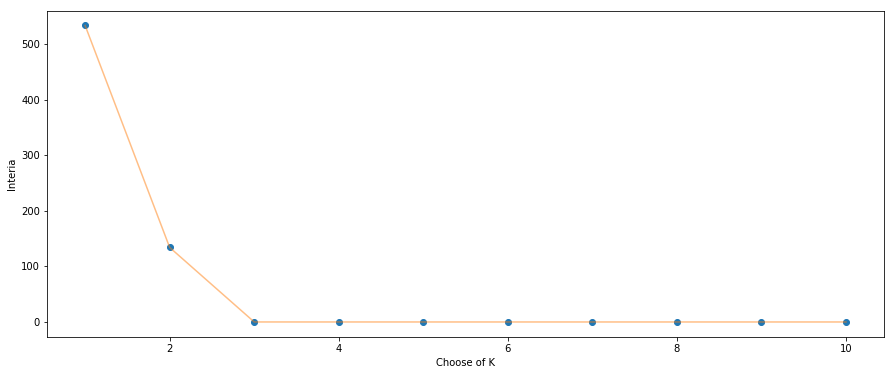

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
X = scores[index_user].detach().numpy()
df_graph = pd.DataFrame(columns=['first','second','third','label'])
df_graph['first'] = X[:,0]
df_graph['second'] = X[:,1]
df_graph['third'] = X[:,2]
df1 = df_graph[['first','second','third']].iloc[:,:].values
inertia = []

for k in range(1,11):
    algorithm = (KMeans(n_clusters=k,
                       init="k-means++",
                       n_init=10,
                       max_iter=300,
                       tol=0.0001,
                       random_state=111,
                       algorithm="full"))
    algorithm.fit(df1)
    inertia.append(algorithm.inertia_)
plt.figure(1,figsize=(15,6))
plt.plot(np.arange(1,11), inertia, 'o')
plt.plot(np.arange(1,11), inertia, '-', alpha=0.5)

plt.xlabel("Choose of K")
plt.ylabel("Interia")
plt.show()

In [ ]:
n_clusters = 3
estimators = KMeans(n_clusters=n_clusters)
estimators.fit(X)
labele = estimators.labels_
df_graph['label'] = labele

Cluster: 0 0.0005816721 0.0007794034 0.9986389


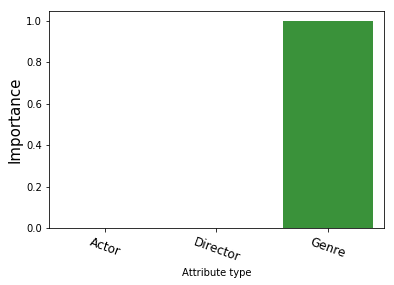

Cluster: 1 0.99969906 0.00025151324 4.9396203e-05


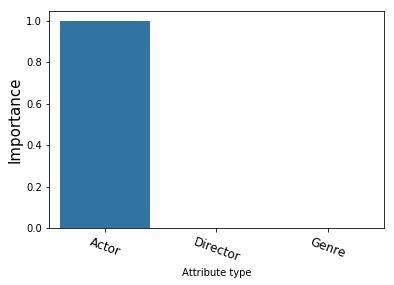

Cluster: 2 0.0008009133 0.99780124 0.0013977317


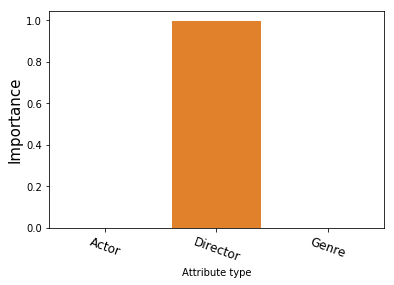

In [ ]:
import seaborn as sns
for i in range(n_clusters):
    print("Cluster:", i, df_graph[df_graph['label'] == i]['first'].mean(),df_graph[df_graph['label'] == i]['second'].mean(),df_graph[df_graph['label'] == i]['third'].mean())
    import matplotlib.pyplot as plt
    plt.xlabel('Attribute type')
    plt.ylabel('Importance',fontsize=15)
    name_list = ['Actor', 'Director','Genre']
    num_list = [df_graph[df_graph['label'] == i]['first'].mean(),df_graph[df_graph['label'] == i]['second'].mean(),df_graph[df_graph['label'] == i]['third'].mean()]

    hist_fig = sns.barplot(x = name_list, y = num_list,tick_label=name_list)
    plt.xticks(fontsize  = 'large',rotation=-20)
    #plt.savefig('/home/jinfeng/Downloads/doctorant/Conférences/dsaa/argumrntative/test2.png')

    plt.show()


No handles with labels found to put in legend.


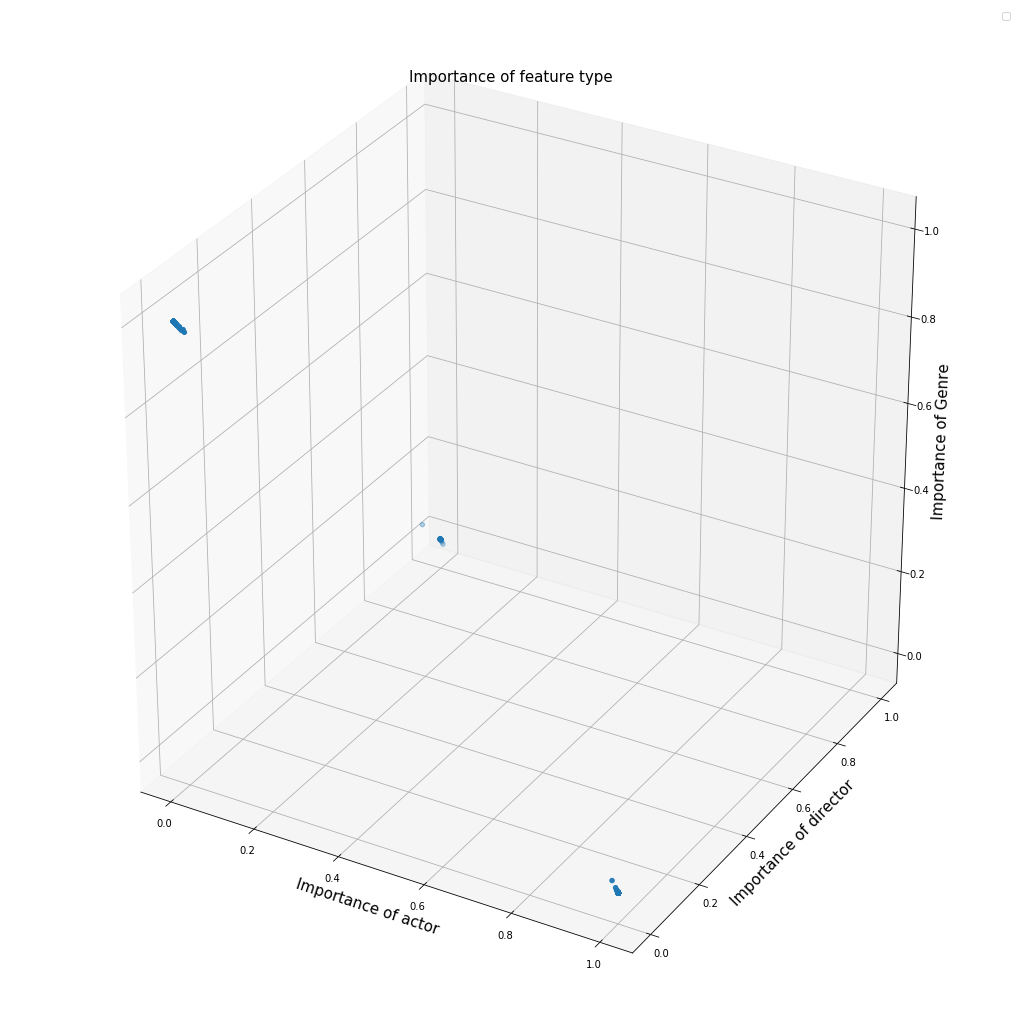

In [ ]:

from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization!
fig = plt.figure(figsize=(14, 14))
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2])

ax.set_title("Importance of feature type",fontsize=15)
ax.set_xlabel('Importance of actor',fontsize=15)
ax.set_ylabel('Importance of director',fontsize=15)
ax.set_zlabel('Importance of Genre',fontsize=15)

ax.legend()
plt.show()




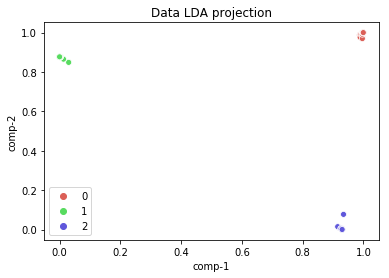

In [ ]:
# Step 2: Apply Linear Discriminant Analysis to reduce dimension to 2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, labele)

import seaborn as sns
x_min, x_max = np.min(X_lda, 0), np.max(X_lda, 0)
X_lda = (X_lda - x_min) / (x_max - x_min)
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = X_lda[:,0]
df["comp-2"] = X_lda[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="Data LDA projection")
plt.show()

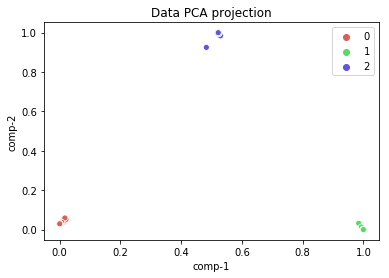

In [ ]:
from sklearn.decomposition import PCA
result = PCA(n_components=2).fit_transform(X)
x_min, x_max = np.min(result, 0), np.max(result, 0)
result = (result - x_min) / (x_max - x_min)
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = result[:,0]
df["comp-2"] = result[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="Data PCA projection")
#plt.savefig('cluster_pca.png')
plt.show()


Starting compute t-SNE Embedding...


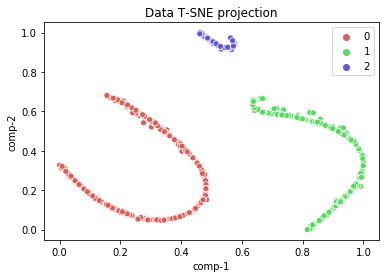

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
data, label, n_samples, n_features,title = X, labele, 38616, 3,'Cluster of users according to importances of contexts'
print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)

result = ts.fit_transform(data)

x_min, x_max = np.min(result, 0), np.max(result, 0)
result = (result - x_min) / (x_max - x_min)
import seaborn as sns
df = pd.DataFrame()
df["y"] = labele
df["comp-1"] = result[:,0]
df["comp-2"] = result[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="Data T-SNE projection")
plt.show()